# GR00T Inference

This tutorial shows how to use the GR00T inference model to predict the actions from the observations, given a test dataset.

In [1]:
import os
import torch
import gr00t

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy

objc[19545]: Class AVFFrameReceiver is implemented in both /opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/av/.dylibs/libavdevice.60.3.100.dylib (0x31dbb8760) and /opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/decord/.dylibs/libavdevice.59.7.100.dylib (0x346414a10). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[19545]: Class AVFAudioReceiver is implemented in both /opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/av/.dylibs/libavdevice.60.3.100.dylib (0x31dbb87b0) and /opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/decord/.dylibs/libavdevice.59.7.100.dylib (0x346414a60). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrad

In [2]:
# change the following paths
MODEL_PATH = "nvidia/GR00T-N1.5-3B"

# REPO_PATH is the path of the pip install gr00t repo and one level up
REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATASET_PATH = os.path.join(REPO_PATH, "demo_data/robot_sim.PickNPlace")
EMBODIMENT_TAG = "gr1"

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

## Loading Pretrained Policy

Policy Model is loaded just like any other huggingface model.

There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [3]:
from gr00t.experiment.data_config import DATA_CONFIG_MAP


data_config = DATA_CONFIG_MAP["fourier_gr1_arms_only"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()

policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

# print out the policy model architecture
print(policy.model)

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Loading pretrained dual brain from /Users/apple/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/b636b0d51a6c4514d39e1e88b8f04c15a74933b2
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /Users/apple/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/b636b0d51a6c4514d39e1e88b8f04c15a74933b2
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
GR00T_N1_5(
  (backbone): EagleBackbone(
    (eagle_model): Eagle2_5_VLForConditionalGeneration(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear(in_features=1152, out_f

## Loading dataset

First this requires user to check which embodiment tags are used to pretrained the `Gr00tPolicy` pretrained models.

In [4]:
import numpy as np

modality_config = policy.modality_config

print(modality_config.keys())

for key, value in modality_config.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


dict_keys(['video', 'state', 'action', 'language'])
video delta_indices=[0] modality_keys=['video.ego_view']
state delta_indices=[0] modality_keys=['state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand']
action delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] modality_keys=['action.left_arm', 'action.right_arm', 'action.left_hand', 'action.right_hand']
language delta_indices=[0] modality_keys=['annotation.human.action.task_description']


In [5]:
# Create the dataset
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset robot_sim.PickNPlace with gr1


Let's print out a single data and visualize it

In [6]:
import numpy as np

step_data = dataset[0]

print(step_data)

print("\n\n ====================================")
for key, value in step_data.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


{'video.ego_view': array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8), 'state.left_arm': array([[-0.01147083,  0.12207967,  0.04229397, -2.1       , -0.01441445,
        -0.03013532, -0.00384387]]), 'state.r

Let's plot just the "right hand" state and action data and see how it looks like. Also show the images of the right hand state.

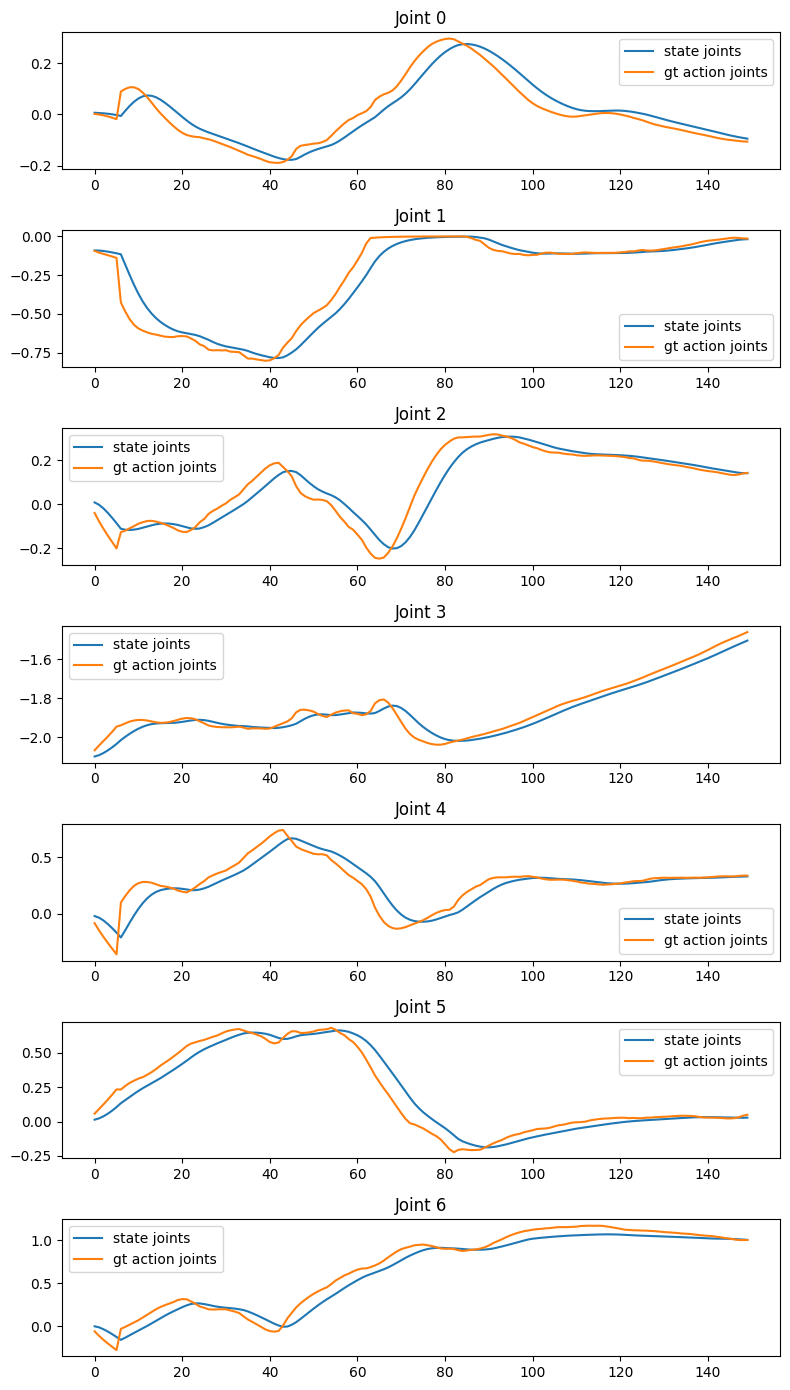

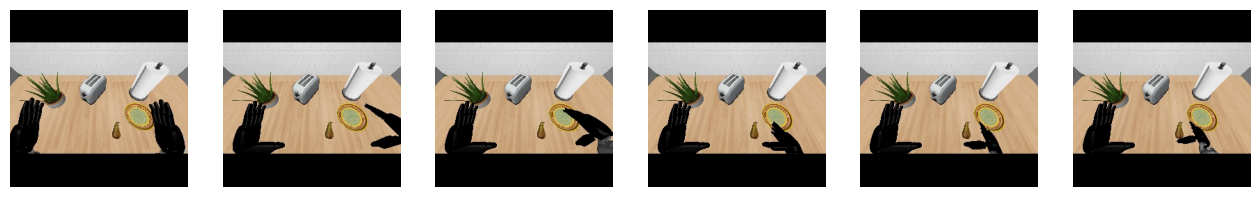

In [7]:
import matplotlib.pyplot as plt

traj_id = 0
max_steps = 150

state_joints_across_time = []
gt_action_joints_across_time = []
images = []

sample_images = 6

for step_count in range(max_steps):
    data_point = dataset.get_step_data(traj_id, step_count)
    state_joints = data_point["state.right_arm"][0]
    gt_action_joints = data_point["action.right_arm"][0]
    
   
    state_joints_across_time.append(state_joints)
    gt_action_joints_across_time.append(gt_action_joints)

    # We can also get the image data
    if step_count % (max_steps // sample_images) == 0:
        image = data_point["video.ego_view"][0]
        images.append(image)

# Size is (max_steps, num_joints == 7)
state_joints_across_time = np.array(state_joints_across_time)
gt_action_joints_across_time = np.array(gt_action_joints_across_time)


# Plot the joint angles across time
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 2*7))

for i, ax in enumerate(axes):
    ax.plot(state_joints_across_time[:, i], label="state joints")
    ax.plot(gt_action_joints_across_time[:, i], label="gt action joints")
    ax.set_title(f"Joint {i}")
    ax.legend()

plt.tight_layout()
plt.show()


# Plot the images in a row
fig, axes = plt.subplots(nrows=1, ncols=sample_images, figsize=(16, 4))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis("off")
    

Now we can run the policy from the pretrained checkpoint.

In [8]:
predicted_action = policy.get_action(step_data)
for key, value in predicted_action.items():
    print(key, value.shape)

action.left_arm (16, 7)
action.right_arm (16, 7)
action.left_hand (16, 6)
action.right_hand (16, 6)


/Users/apple/Documents/Isaac-GR00T/gr00t/model/action_head/cross_attention_dit.py:281: FutureWarning: Accessing config attribute `interleave_self_attention` directly via 'DiT' object attribute is deprecated. Please access 'interleave_self_attention' over 'DiT's config object instead, e.g. 'unet.config.interleave_self_attention'.
  if idx % 2 == 1 and self.interleave_self_attention:


### Understanding the Action Output

Each joint in the action output has a shape of (16, N) where N is the degree of freedom for the joint.
- 16 represents the action horizon (predictions for timesteps t, t+1, t+2, ..., t+15)

For each arm (left and right):
- 7 arm joints:
  - Shoulder pitch
  - Shoulder roll
  - Shoulder yaw
  - Elbow pitch
  - Wrist yaw
  - Wrist roll
  - Wrist pitch

For each hand (left and right):
- 6 finger joints:
  - Little finger
  - Ring finger
  - Middle finger
  - Index finger
  - Thumb rotation
  - Thumb bending

For the waist
- 3 joints:
  - torso waist yaw
  - torso waist pitch
  - torso waist roll
